# GIS Analysis techniques 2: Final Project
## Childcare and Education Accessibility in Graz
#### Group 2: Conni S., Paul B., Elias P., Miriam E. 
---
#### 💡 Aim of the Project: evaluate the walking access to childcare facilities and schools and compare different cities’ family-friendliness

---
---

### Settings

In [88]:
# install necessary libraries
!pip install geopandas keplergl osmnx networkx shapely pandas numpy matplotlib rasterio rasterstats h3


In [89]:
# import necessary libraries
# Geospatial
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, box, mapping
import h3
import rasterio
from rasterstats import zonal_stats

# Data handling
import pandas as pd
import numpy as np
import os
from pathlib import Path
from rasterio.mask import mask


# Visualization
import matplotlib.pyplot as plt
from keplergl import KeplerGl

#### Define the paths for the Grid & Population Data

In [90]:
# Relative paths (don't worry about this code - you can just run it as is)
project_root = Path.cwd()  
raw_dir = project_root / "Data" / "Raw"
processed_dir = project_root / "Data" / "Processed"
os.makedirs(processed_dir, exist_ok=True)

---

# Part A: Graz, Austria

## Part A.1: Data Preparation

#### Define and import Study Area

In [91]:
# define the study area place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
target_crs = 31256
gdf_graz = gdf_graz.to_crs(epsg=target_crs)

In [92]:
# Get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=target_crs)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

👀 Inspect the Results of the Study Area

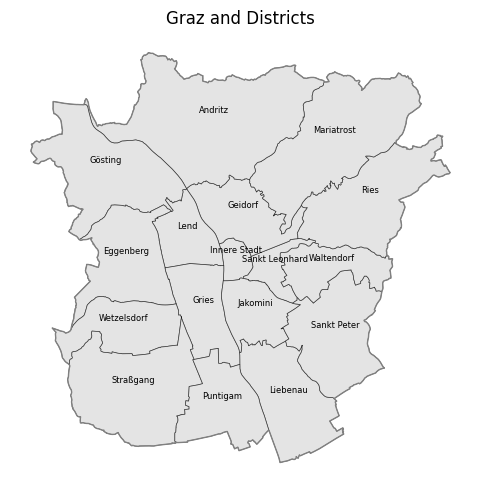

In [93]:
# Quick plot of Graz boundary and districts with labels
fig, ax = plt.subplots(figsize=(5, 5))
gdf_graz.boundary.plot(ax=ax, color='grey', linewidth=1)
gdf_districts.plot(ax=ax, color='lightgray', alpha=0.6, edgecolor='black', linewidth=0.5)

# Add district labels at centroids
gdf_districts['centroid'] = gdf_districts.geometry.centroid
for idx, row in gdf_districts.iterrows():
    ax.annotate(text=row['name'], xy=row['centroid'].coords[0], 
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=6)

ax.set_axis_off()
ax.set_title('Graz and Districts')
plt.tight_layout()
plt.show()


#### Get the OSM Data for Childcare facilities and schools

In [94]:
#define tags for childcare facilities and schools from OSMnx
tags = {
    "amenity": [
        "kindergarten",
        "childcare",
        "school"
    ]
}

# Download childcare facilities and schools within Graz boundary - 
# term "education" will be used here for childcare and education to simplify it 
gdf_education_orig = ox.features_from_place(place_name, tags=tags)

# Keep valid geometries and drop null geometries
gdf_education_orig = gdf_education_orig[gdf_education_orig.geometry.notnull()]

# Reproject to target CRS
gdf_education_orig = gdf_education_orig.to_crs(epsg=target_crs)

# convert all geometries to points
gdf_education_orig['geometry'] = gdf_education_orig.geometry.centroid

Check the OSMnx data wether we need to keep everything

In [95]:
# have a quick look at the OSMnx data
gdf_education_orig.head()

geometry       amenity  \
element id                                                       
node    117124121  POINT (-64531.412 212346.337)        school   
        270508838   POINT (-70741.166 215410.99)        school   
        270508839    POINT (-70722.31 215559.89)  kindergarten   
        270508846   POINT (-70563.47 217508.236)        school   
        280451771  POINT (-68282.012 214669.159)        school   

                                                           name addr:city  \
element id                                                                  
node    117124121                                 Waldorfschule       NaN   
        270508838                        Volksschule Algersdorf      Graz   
        270508839  Städtischer Kindergarten Algersdorfer Straße      Graz   
        270508846                                     HTL BULME      Graz   
        280451771               Johann Josef Fux Konservatorium       NaN   

                  addr:country addr:housenumber addr:postcode  \
element id                                                      
node    117124121          NaN              NaN           NaN   
        270508838           AT                9          8020   
        270508839           AT               15          8020   
        270508846           AT            15-21          8051   
        280451771          NaN              NaN           NaN   

                           addr:street     contact:phone isced:level  ...  \
element id                                                            ...   
node    117124121                  NaN               NaN         NaN  ...   
        270508838  Algersdorfer Straße  +43 316 872-6763           1  ...   
        270508839   Algersdorferstraße  +43 316 872 2601         NaN  ...   
        270508846         Ibererstraße               NaN         NaN  ...   
        280451771                  NaN               NaN         NaN  ...   

                  opening_date opening_hours:url building:material  \
element id                                                           
node    117124121          NaN               NaN               NaN   
        270508838          NaN               NaN               NaN   
        270508839          NaN               NaN               NaN   
        270508846          NaN               NaN               NaN   
        280451771          NaN               NaN               NaN   

                  addr2:housenumber addr2:street type building:part image  \
element id                                                                  
node    117124121               NaN          NaN  NaN           NaN   NaN   
        270508838               NaN          NaN  NaN           NaN   NaN   
        270508839               NaN          NaN  NaN           NaN   NaN   
        270508846               NaN          NaN  NaN           NaN   NaN   
        280451771               NaN          NaN  NaN           NaN   NaN   

                  loc_name tourism  
element id                          
node    117124121      NaN     NaN  
        270508838      NaN     NaN  
        270508839      NaN     NaN  
        270508846      NaN     NaN  
        280451771      NaN     NaN  

[5 rows x 88 columns]

Data Cleaning

In [96]:
# only keep columns 'amenity' and 'geometry'
cols_to_keep = ['amenity', 'geometry']
gdf_education = gdf_education_orig[cols_to_keep]
gdf_education.head()

amenity                       geometry
element id                                                    
node    117124121        school  POINT (-64531.412 212346.337)
        270508838        school   POINT (-70741.166 215410.99)
        270508839  kindergarten    POINT (-70722.31 215559.89)
        270508846        school   POINT (-70563.47 217508.236)
        280451771        school  POINT (-68282.012 214669.159)

👀 Have a closer look at the facilities with Kepler Map

In [97]:
# Create a KeplerGl map 
map_1 = KeplerGl(height=600)
# add facilities data
map_1.add_data(data=gdf_education, name="Childcare and Schools")
# display the map
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Childcare and Schools': {'index': [('node', 117124121), ('node', 270508838), ('node', 27050883…

#### Get the Walking Network

In [98]:
# Download walkable street network for Graz

# Custom filter to include bridges, footways, paths because using only "type=walk" filter misses these ways
custom_filter = '["highway"~"primary|secondary|tertiary|residential|unclassified|service|pedestrian|living_street|footway|path|steps|cycleway|track"]["bridge"!~"no"]["foot"!~"no"]'

# Download the walkable street network with custom filter
G_walk = ox.graph_from_place(
    place_name,
    network_type='walk',  # Base walk filter 
    custom_filter=custom_filter, #apply filter additionally
    retain_all=True,
    simplify=True
)

👀 Have a closer look at the network with Kepler Maps

In [99]:
# Visualize the walkable street network in Kepler 
map_2 = KeplerGl(height=600)
# add walkable street network data
map_2.add_data(data=ox.graph_to_gdfs(G_walk, nodes=False, edges=True), name="Walkable Street Network")
# display the map
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Uni\anaconda3\envs\GISAnalys2VU\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'Walkable Street Network': {'index': [(20824406, 1450590079, 0), (20824406, 11535110095, 0), (2…

#### Create H3 Grid

In [100]:
# Create H3 hexagon grid for Graz

# First, convert Graz boundary to WGS84 (EPSG:4326) as H3 requires lat/lon coordinates
gdf_graz_wgs84 = gdf_graz.to_crs(epsg=4326)

# Get the boundary geometry
graz_boundary = gdf_graz_wgs84.geometry.iloc[0]

# H3 resolution 8 gives hexagons with average edge length of ~461m
# H3 resolution 9 gives hexagons with average edge length of ~174m
# We'll use resolution 8 for your 400-500m requirement
h3_resolution = 8

# Convert Shapely polygon to H3 LatLngPoly format
# Extract exterior coordinates and convert from (lon, lat) to (lat, lon)
exterior_coords = list(graz_boundary.exterior.coords)
outer_ring = [(lat, lon) for lon, lat in exterior_coords]

# Create H3 LatLngPoly object
h3_poly = h3.LatLngPoly(outer_ring)

# Get H3 hexagons that cover the Graz boundary
h3_hexagons = h3.h3shape_to_cells(h3_poly, h3_resolution)

print(f"Number of H3 hexagons covering Graz: {len(h3_hexagons)}")

# Convert H3 hexagons to polygons
hexagon_polygons_graz = []
hexagon_ids_graz = []

for hexagon in h3_hexagons:
    # Get the boundary of each hexagon as lat/lon coordinates
    hexagon_boundary = h3.cell_to_boundary(hexagon)
    # Create a Shapely polygon (convert from (lat, lon) to (lon, lat))
    hexagon_polygon = Polygon([(lon, lat) for lat, lon in hexagon_boundary])
    hexagon_polygons_graz.append(hexagon_polygon)
    hexagon_ids_graz.append(hexagon)

# Create a GeoDataFrame with the hexagons
gdf_hexagons_graz = gpd.GeoDataFrame(
    {'h3_id': hexagon_ids_graz},
    geometry=hexagon_polygons_graz,
    crs='EPSG:4326'
)

# Reproject to Austrian metric CRS
gdf_hexagons_graz = gdf_hexagons_graz.to_crs(epsg=target_crs)

# Add hexagon area in square meters
gdf_hexagons_graz['area_m2'] = gdf_hexagons_graz.geometry.area

# Add hexagon centroid for reference
gdf_hexagons_graz['centroid'] = gdf_hexagons_graz.geometry.centroid

print(f"\nHexagon grid statistics:")
print(f"Average hexagon area: {gdf_hexagons_graz['area_m2'].mean():.2f} m²")
print(f"Average hexagon 'diameter': {np.sqrt(gdf_hexagons_graz['area_m2'].mean() / 0.866):.2f} m")

# Display first few rows
gdf_hexagons_graz.head()

Number of H3 hexagons covering Graz: 177

Hexagon grid statistics:
Average hexagon area: 742928.03 m²
Average hexagon 'diameter': 926.22 m


,h3_id,geometry,area_m2,centroid
0,881e10a159fffff,"POLYGON ((-66439.547 220094.761, -66611.405 21...",742513.150679,POINT (-66074.325 219719.3)
1,881e10aa23fffff,"POLYGON ((-72757.771 210319.814, -72929.838 20...",743410.564451,POINT (-72392.563 209943.945)
2,881e10a117fffff,"POLYGON ((-64763.467 216338.315, -64935.322 21...",743020.099703,POINT (-64398.115 215962.671)
3,881e10aadbfffff,"POLYGON ((-64182.915 213707.498, -64354.78 213...",743351.467885,POINT (-63817.491 213331.73)
4,881e10b887fffff,"POLYGON ((-73593.102 217961.736, -73765.123 21...",742481.907524,POINT (-73228.073 217586.221)


👀 Let's have a quick look at the grid

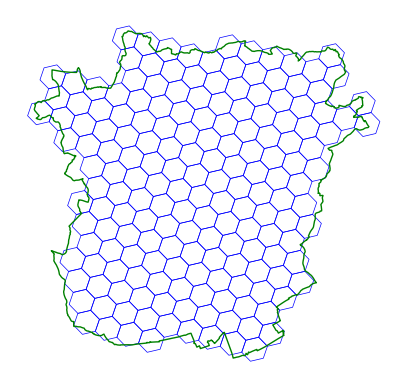

In [101]:
# Have a quick look at the hexagon grid as a plot
fig, ax = plt.subplots(figsize=(5, 5))
gdf_hexagons_graz.boundary.plot(ax=ax, color='blue', linewidth=
0.5)
gdf_graz.boundary.plot(ax=ax, color='green', linewidth=1)
ax.set_axis_off()
plt.show()


#### Population Data from the Global Human Settlement Layer

First, we will check the CRS again to be sure

In [102]:
# Step 1: Check CRS match
print("Step 1: CRS info")
print(f"Hexagons CRS: {gdf_hexagons_graz.crs}")
print(f"Hexagons count: {len(gdf_hexagons_graz)}")

Step 1: CRS info
Hexagons CRS: EPSG:31256
Hexagons count: 177


##### Import and aggregate the data
💡 The .tif file is rather large (cannot be saved on GitHub) and if saved locally, no one else could run the script top-to-bottom (unless downloading the data, saving it locally, changing paths, etc.). So this is why we work with an if-else function. If the raw .tif file can be found, then this will be used, and if it not (of course it cannot be found since it't too large), then the aggregated GeoParquet will be used. This is saved in the Data/Processed Order on GitHub and anyone can load it with this code without needing to download something or changing parts of the code.

In [103]:
# Define file paths
ghsl_file_graz = raw_dir / "GHS_POP_GRAZ_RAW.tif"
ghsl_pop_graz_path = processed_dir / "ghsl_pop_graz.parquet"

# Check if processed file already exists
if ghsl_pop_graz_path.exists():
    print("Processed file already exists. Loading existing data to preserve any modifications...")
    gdf_hexagons_graz = gpd.read_parquet(ghsl_pop_graz_path)
    print(f"Loaded pre-aggregated GHSL data from {ghsl_pop_graz_path}")
    print(f"Total population: {gdf_hexagons_graz['population'].sum():,.0f}")
    
elif ghsl_file_graz.exists():
    print("Processing GHSL population data for Graz (first time)...")
    pop_values = []
    
    with rasterio.open(ghsl_file_graz) as src:
        print(f"GHSL CRS: {src.crs}")
        print(f"GHSL bounds: {src.bounds}")
        
        # Reproject hexagons to match GHSL CRS
        hex_src_crs = gdf_hexagons_graz.to_crs(src.crs)
        
        for idx, hex_row in hex_src_crs.iterrows():
            try:
                # Zonal sum: total population per hexagon
                out_image, _ = mask(src, [hex_row.geometry], crop=True, nodata=0, filled=True)
                # Sum only positive values (population can't be negative)
                pop_sum = np.nansum(out_image[out_image > 0])
                pop_values.append(pop_sum if pop_sum > 0 else 0)
            except ValueError:
                # Hexagon outside raster bounds
                pop_values.append(0)
        
        print(f"Processed {len(pop_values)} hexagons")
    
    # Add population data to hexagons
    gdf_hexagons_graz['population'] = pop_values
    gdf_hexagons_graz['pop_density'] = gdf_hexagons_graz['population'] / gdf_hexagons_graz['area_m2']
    
    # Save aggregated data
    gdf_hexagons_graz.to_parquet(ghsl_pop_graz_path)
    print(f"Saved {len(gdf_hexagons_graz)} hexagons with population to {ghsl_pop_graz_path}")
    print(f"Total population: {gdf_hexagons_graz['population'].sum():,.0f}")
    
else:
    raise FileNotFoundError(f"Neither raw GHSL file nor processed data found!\n"
                          f"Raw file expected at: {ghsl_file_graz}\n"
                          f"Processed file expected at: {ghsl_pop_graz_path}")

# Display summary statistics
print("\nPopulation statistics per hexagon:")
print(gdf_hexagons_graz[['population', 'pop_density']].describe())

# Show top 10 hexagons by population
print("\nTop 10 hexagons by population:")
print(gdf_hexagons_graz.nlargest(10, 'population')[['h3_id', 'population', 'pop_density']])

Processed file already exists. Loading existing data to preserve any modifications...
Loaded pre-aggregated GHSL data from c:\Users\Uni\Desktop\Uni\Master\Semester 5\GisAnalyse 2 VU\GIS_FinalProject_Group2\Data\Processed\ghsl_pop_graz.parquet
Total population: 333,287

Population statistics per hexagon:
        population  pop_density
count   177.000000   177.000000
mean   1882.977528     0.002534
std    1940.252174     0.002611
min       0.000000     0.000000
25%     206.501989     0.000278
50%    1510.521323     0.002035
75%    2997.601563     0.004034
max    9616.629941     0.012942

Top 10 hexagons by population:
               h3_id   population  pop_density
26   881e10a121fffff  9616.629941     0.012942
105  881e10a123fffff  9303.767445     0.012520
119  881e10a107fffff  7304.253241     0.009832
13   881e10a13dfffff  7160.403779     0.009637
126  881e10a12dfffff  6693.606262     0.009009
51   881e10a12bfffff  6580.331978     0.008857
25   881e10a163fffff  6423.558174     0.008648

👀 Let's have a closer look at the population data using Kepler

In [104]:
# Visualize hexagon population data in KeplerGl
map_3 = KeplerGl(height=600)
map_3.add_data(data=gdf_hexagons_graz, name="Graz H3 Population")
map_3 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz H3 Population': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

Let's check if the CRS are correct and the same!

In [105]:
print("gdf_hexagons_graz CRS:", gdf_hexagons_graz.crs)
print("target_crs:", target_crs)
print("Match?", gdf_hexagons_graz.crs == target_crs)


gdf_hexagons_graz CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "MGI / Austria GK East", "base_crs": {"name": "MGI", "datum": {"type": "GeodeticReferenceFrame", "name": "Militar-Geographische Institut", "ellipsoid": {"name": "Bessel 1841", "semi_major_axis": 6377397.155, "inverse_flattening": 299.1528128}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 4312}}, "conversion": {"name": "Austria Gauss-Kruger East", "method": {"name": "Transverse Mercator", "id": {"authority": "EPSG", "code": 9807}}, "parameters": [{"name": "Latitude of natural origin", "value": 0, "unit": "degree", "id": {"authority": "EPSG", "code": 8801}}, {"name": "Longitude of natural origin", "value": 16.3333333333333, "unit": "d

#### Get Slope for more realistic walking time

DEM(OpenTopography (n.d.). Copernicus GLO-30 Digital Elevation Model. https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3. (Accessed January
10, 2026))

load the digital elevation model file dem_graz_4326.tif. First check if the file actually exists; if not, the code stops with an error message so we notice the missing DEM. Then open the DEM with Rasterio, print a short confirmation that it was loaded successfully, and read its coordinate reference system (CRS) into the variable dem_crs

In [106]:
# 1) Load DEM and store its CRS
dem_path = processed_dir / "dem_graz_4326.tif"

if not dem_path.exists():
    raise FileNotFoundError(
        f"DEM file {dem_path} is missing. "
        "Make sure you ran `git pull` and that the file is in Data/Processed."
    )

with rasterio.open(dem_path) as src_dem:
    print("DEM loaded successfully.")
    print("DEM CRS:", src_dem.crs)
    dem_crs = src_dem.crs   


DEM loaded successfully.
DEM CRS: EPSG:4326


Tobler Function (α = 6 km/h, b = 3.5 and c = 0.05)

Arthur Goodwin, Megan Hammett, Myles Harris,
The application of Tobler's hiking function in data-driven traverse modelling for planetary exploration,
Acta Astronautica,
Volume 228,
2025,
Pages 265-273,
ISSN 0094-5765,
https://doi.org/10.1016/j.actaastro.2024.12.005.

convert the walking network into two GeoDataFrames, one for nodes and one for edges, and I print their coordinate system


In [107]:
# 2) Convert graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G_walk)
print("Nodes CRS:", nodes.crs)
print("Edges CRS:", edges.crs)

Nodes CRS: epsg:4326
Edges CRS: epsg:4326


Make sure that the node coordinates use the same CRS as the DEM. If not, reproject the nodes. Then take the x/y coordinates of all nodes, sample the DEM at these locations, and store the resulting elevation values in a new column called elev. Now every node has a height in meters.

In [108]:
# 3) Reproject nodes to DEM CRS (if needed) and sample elevation
if nodes.crs != dem_crs:
    nodes_dem = nodes.to_crs(dem_crs)
else:
    nodes_dem = nodes.copy()

coords = list(zip(nodes_dem.geometry.x, nodes_dem.geometry.y))

with rasterio.open(dem_path) as src:
    elevation_values = [val[0] for val in src.sample(coords)]

nodes["elev"] = elevation_values
print(nodes[["elev"]].describe())

               elev
count  59445.000000
mean     378.403442
std       45.144012
min      327.500000
25%      354.875305
50%      364.181915
75%      380.735352
max      757.322021


attach the elevation of the start node and the end node to each edge. From these two heights calculate the elevation difference dz and the horizontal distance dx of each edge. The slope is simply dz / dx. also replace zero distances to avoid division by zero

In [109]:
# 4) Compute slope and Tobler-based travel time on edges
edges = edges.merge(nodes["elev"], left_on="u", right_index=True, how="left") \
             .rename(columns={"elev": "elev_u"})
edges = edges.merge(nodes["elev"], left_on="v", right_index=True, how="left") \
             .rename(columns={"elev": "elev_v"})

edges["dz"] = edges["elev_v"] - edges["elev_u"]          # elevation change (m)
edges["dx"] = edges.geometry.length                      # horizontal distance (m)
edges["dx"] = edges["dx"].replace(0, np.nan)             # avoid division by zero

edges["slope"] = edges["dz"] / edges["dx"]               # gradient

C:\Users\Uni\AppData\Local\Temp\ipykernel_10836\534095239.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges["dx"] = edges.geometry.length                      # horizontal distance (m)


Very extreme slopes are then clamped between −1 and +1 so that the formula works reliably. After that, apply Tobler’s hiking function to the clamped slope to get a realistic walking speed in km/h. Also enforce a minimum speed of 0.5 km/h to never get zero speed.

In [110]:
# Clamp extreme slopes to avoid numerical issues
max_abs_slope = 1.0
edges["slope_clamped"] = edges["slope"].clip(lower=-max_abs_slope, upper=max_abs_slope)

# Tobler's hiking function with clamped slope: W = 6 * exp(-3.5 * |slope + 0.05|)
edges["speed_kmh"] = 6 * np.exp(-3.5 * np.abs(edges["slope_clamped"] + 0.05))

# Enforce a minimum speed to avoid zeros (0.5 km/h)
min_speed_kmh = 0.5
edges["speed_kmh"] = edges["speed_kmh"].clip(lower=min_speed_kmh)

convert the walking speed from km/h to m/s and use it together with the edge length to calculate a slope‑adjusted travel time in seconds for each edge. This travel time is stored in the column travel_time_slope

In [111]:

edges["speed_ms"] = edges["speed_kmh"] * 1000 / 3600.0
edges["travel_time_slope"] = edges["dx"] / edges["speed_ms"]  # seconds

print(edges[["dx", "dz", "slope", "slope_clamped", "speed_kmh", "travel_time_slope"]].head())


                                dx        dz         slope  slope_clamped  \
u        v           key                                                    
20824406 1450590079  0    0.000587 -0.321075   -547.362957           -1.0   
         11535110095 0    0.000133 -1.504242 -11343.105769           -1.0   
         35127847    0    0.000436 -5.714172 -13107.839248           -1.0   
20824622 2206059996  0    0.000114  0.000000      0.000000            0.0   
         1450590160  0    0.000137 -1.725494 -12618.578967           -1.0   

                          speed_kmh  travel_time_slope  
u        v           key                                
20824406 1450590079  0     0.500000           0.004223  
         11535110095 0     0.500000           0.000955  
         35127847    0     0.500000           0.003139  
20824622 2206059996  0     5.036742           0.000081  
         1450590160  0     0.500000           0.000985  


The updated nodes and edges, rebuild the network as a new graph called G_slope. This graph is now slope‑aware, because each edge weight represents a realistic walking time that includes uphill and downhill effects.

In [112]:
# 5) Build slope-aware graph
G_slope = ox.graph_from_gdfs(nodes, edges)
print("Slope-aware graph built.")

Slope-aware graph built.


## Part A.2: Accessibility Calculation
for each H3 hexagon, compute slope‑adjusted walking time to the nearest childcare/kindergarten and the nearest school.

Snap hexagon centroids to nearest network nodes

Check the CRS of the hexagons and the network. Then reproject the hexagons to the same CRS as the network so the coordinates match. For each hexagon centroid, find the nearest node in the slope‑aware network and store its ID in a new column nearest_node. This links every hexagon cell to a specific network node

In [113]:
# 1) Snap hexagon centroids to nearest network nodes
print("Hexagon CRS:", gdf_hexagons_graz.crs)
print("Network CRS:", nodes.crs)

# Reproject hexagons to network CRS (for snapping)
gdf_hexagons_graz_net = gdf_hexagons_graz.to_crs(nodes.crs)

hex_centroids = gdf_hexagons_graz_net["centroid"]
hex_x = hex_centroids.x.values
hex_y = hex_centroids.y.values

hex_nearest_nodes = ox.distance.nearest_nodes(
    G_slope, X=hex_x, Y=hex_y
)

# Store nearest node IDs back on original hexagon frame (in 31256)
gdf_hexagons_graz["nearest_node"] = hex_nearest_nodes

Hexagon CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "MGI / Austria GK East", "base_crs": {"name": "MGI", "datum": {"type": "GeodeticReferenceFrame", "name": "Militar-Geographische Institut", "ellipsoid": {"name": "Bessel 1841", "semi_major_axis": 6377397.155, "inverse_flattening": 299.1528128}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 4312}}, "conversion": {"name": "Austria Gauss-Kruger East", "method": {"name": "Transverse Mercator", "id": {"authority": "EPSG", "code": 9807}}, "parameters": [{"name": "Latitude of natural origin", "value": 0, "unit": "degree", "id": {"authority": "EPSG", "code": 8801}}, {"name": "Longitude of natural origin", "value": 16.3333333333333, "unit": "degree", "i

The same for the education points of interest. If their CRS is different from the network, reproject them. Then find the nearest network node for each POI and store it in nearest_node. After that, split the POIs into two groups: childcare/kindergarten and schools. For each group, collect the set of nearest node IDs; these will be the source nodes for the accessibility calculation.

In [114]:
# 2) Snap education POIs to nearest nodes
print("Education CRS:", gdf_education.crs)

if gdf_education.crs != nodes.crs:
    gdf_education_net = gdf_education.to_crs(nodes.crs)
else:
    gdf_education_net = gdf_education.copy()

edu_x = gdf_education_net.geometry.x.values
edu_y = gdf_education_net.geometry.y.values

edu_nearest_nodes = ox.distance.nearest_nodes(
    G_slope, X=edu_x, Y=edu_y
)
gdf_education_net["nearest_node"] = edu_nearest_nodes

# Separate childcare/kindergarten and schools
edu_childcare = gdf_education_net[gdf_education_net["amenity"].isin(["childcare", "kindergarten"])].copy()
edu_schools = gdf_education_net[gdf_education_net["amenity"] == "school"].copy()

childcare_nodes = set(edu_childcare["nearest_node"])
school_nodes = set(edu_schools["nearest_node"])

print(f"Childcare/kindergarten POI nodes: {len(childcare_nodes)}")
print(f"School POI nodes: {len(school_nodes)}")

Education CRS: EPSG:31256
Childcare/kindergarten POI nodes: 154
School POI nodes: 142


Define a function that runs a multi‑source Dijkstra shortest‑path algorithm. It takes a set of source nodes and computes the minimum travel time from any of these sources to every node in the network, using the slope‑based travel time as weight. The result is a dictionary mapping each node ID to its minimum travel time. Call this function once for childcare nodes and once for school nodes

In [115]:
# 3) Multi-source Dijkstra: min travel time from any POI to all nodes
def compute_min_travel_time(graph, source_nodes, weight_attr="travel_time_slope", cutoff=None):

    if not source_nodes:
        return {}
    lengths = nx.multi_source_dijkstra_path_length(
        graph,
        sources=list(source_nodes),
        weight=weight_attr,
        cutoff=cutoff
    )
    return lengths

# These times are currently in HOURS (because travel_time_slope is in hours)
time_to_childcare = compute_min_travel_time(G_slope, childcare_nodes, weight_attr="travel_time_slope")
time_to_school = compute_min_travel_time(G_slope, school_nodes, weight_attr="travel_time_slope")


Each hexagon is linked to one network node through nearest_node. The helper function map_time_to_hex looks up the travel time for that node in the time dictionaries and returns it. Applying this function creates two new columns in the hexagon GeoDataFrame: travel time to the nearest childcare and to the nearest school, both in hours. Finally, convert these hours into minutes and store them in t_childcare_min and t_school_min, which are easier to interpret.

In [116]:

# 4) Attach travel times to hexagons via nearest_node
def map_time_to_hex(row, time_dict):
    node_id = row["nearest_node"]
    return time_dict.get(node_id, np.nan)

gdf_hexagons_graz["t_childcare_h"] = gdf_hexagons_graz.apply(
    lambda row: map_time_to_hex(row, time_to_childcare), axis=1
)
gdf_hexagons_graz["t_school_h"] = gdf_hexagons_graz.apply(
    lambda row: map_time_to_hex(row, time_to_school), axis=1
)

# Interpret current values as HOURS (t_childcare_h / t_school_h) and convert to MINUTES
gdf_hexagons_graz["t_childcare_min"] = gdf_hexagons_graz["t_childcare_h"] * 60.0
gdf_hexagons_graz["t_school_min"] = gdf_hexagons_graz["t_school_h"] * 60.0

print(gdf_hexagons_graz[["t_childcare_h", "t_childcare_min"]].describe())



       t_childcare_h  t_childcare_min
count     137.000000       137.000000
mean        0.220293        13.217556
std         0.091656         5.499387
min         0.041260         2.475591
25%         0.201591        12.095486
50%         0.224001        13.440041
75%         0.257603        15.456204
max         0.375382        22.522950


## Part A.3: Accessibility Indicator ("family-friendliness indicator")

Define a 15‑minute threshold and create three indicator variables for each hexagon. First, has_childcare_15 is 1 if the walking time to the nearest childcare is 15 minutes or less, otherwise 0. Second, has_school_15 is 1 if the walking time to the nearest school is 15 minutes or less, otherwise 0. Finally, family_complete_15 is 1 only if both conditions are true, meaning the hexagon has access to both childcare and school within a 15‑minute walk. At the end, print how many hexagons fall into each of these categories. The 15‑minute threshold follows the common “15‑minute city” idea that basic services should be reachable within about a 15‑minute walk.
​

In [117]:
# Family-friendliness indicators per hexagon (15-minute threshold) 
threshold_min = 15  # minutes

gdf_hexagons_graz["has_childcare_15"] = (
    gdf_hexagons_graz["t_childcare_min"] <= threshold_min
).astype(int)

gdf_hexagons_graz["has_school_15"] = (
    gdf_hexagons_graz["t_school_min"] <= threshold_min
).astype(int)

gdf_hexagons_graz["family_complete_15"] = (
    (gdf_hexagons_graz["has_childcare_15"] == 1) &
    (gdf_hexagons_graz["has_school_15"] == 1)
).astype(int)

print(gdf_hexagons_graz[["has_childcare_15", "has_school_15", "family_complete_15"]].sum())


has_childcare_15      85
has_school_15         84
family_complete_15    73
dtype: int64


Visualisation 

The first map colors each hexagon by family_complete_15 (0 or 1) in green tones and draws the Graz boundary on top, showing where both childcare and school are reachable within 15 minutes.

The second map copies the hexagons, caps t_childcare_min at 30 minutes, and plots this capped value with a continuous “viridis” color scale, again with the city boundary and no axes, showing how long it takes to walk to the nearest childcare

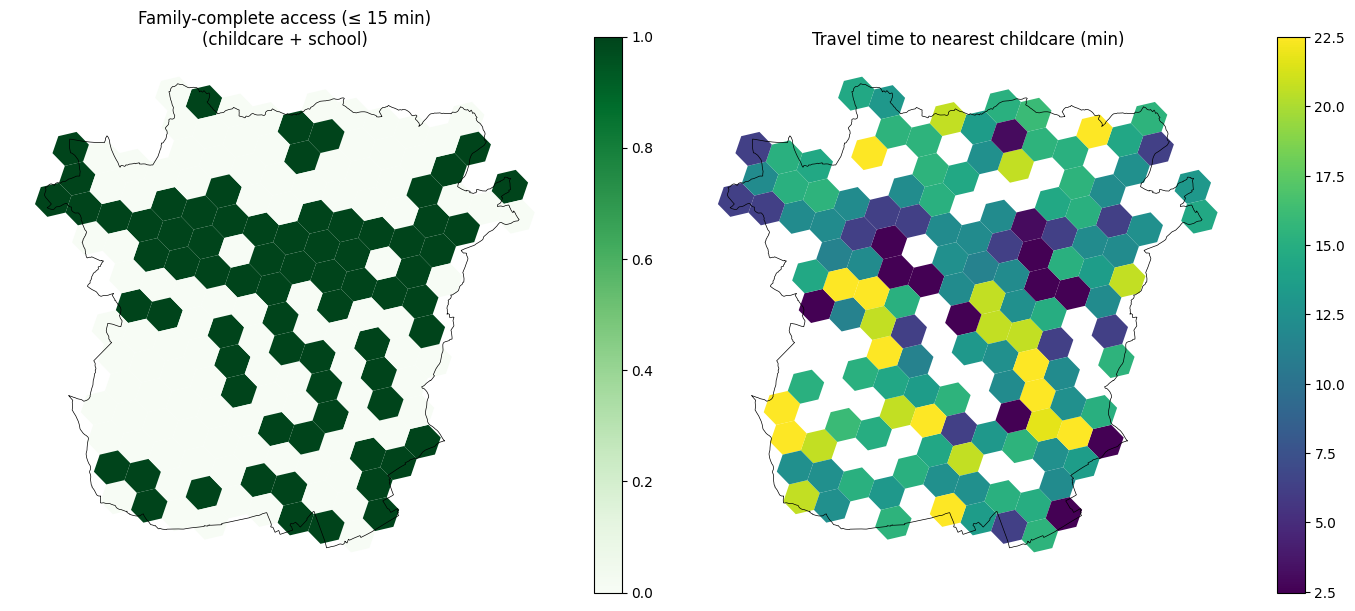

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Family-complete (0/1)
gdf_hexagons_graz.plot(
    column="family_complete_15",
    ax=ax[0],
    legend=True,
    cmap="Greens",
    edgecolor="none"
)
gdf_graz.boundary.plot(ax=ax[0], color="black", linewidth=0.5)
ax[0].set_title("Family-complete access (≤ 15 min)\n(childcare + school)")
ax[0].set_axis_off()

# Plot 2: Travel time to nearest childcare (min, capped at 30)
gdf_hex_plot = gdf_hexagons_graz.copy()
gdf_hex_plot["t_childcare_min_capped"] = gdf_hex_plot["t_childcare_min"].clip(upper=30)

gdf_hex_plot.plot(
    column="t_childcare_min_capped",
    ax=ax[1],
    legend=True,
    cmap="viridis",
    edgecolor="none"
)
gdf_graz.boundary.plot(ax=ax[1], color="black", linewidth=0.5)
ax[1].set_title("Travel time to nearest childcare (min)")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()


---

# Part B: Uppsala, Sweden - _just an idea, because it's know for being very family friendly_

## Part B.1: Data Preparation

!!!ATTENTION: dont use place_name since it is used for graz --> change it!
generally, always put "uppsala" behind every df/gdf to not overwrite existing graz files. (e.g. the Graz Walk network is called G_walk -> make sure to use G_walk_uppsala or something similar!)

## Part B.2: Accesibility Calculation

## Part B.3: Accessibility Indicator ("family-friendliness indicator")

---

# Part C: Statistics, Visualisation & Mapping

## Part C.1: Graz

## Part C.2: Uppsala

## Part C.3: Comparison Maps